# 00. Seminar description

In this seminar, you will become more familiar with the concept of pitch and implement the Monotonic Alignment Search (MAS) algorithm for estimating phoneme durations. Both of these concepts are useful for understanding where the ground truth labels for pitch and durations may come from during the training of the FastPitch architecture.

The seminar consists of two parts. In total, you can earn **5 points** for the seminar.

In [ ]:
# If running in colab

# !pip install praat-parselmouth soundfile librosa

# 01. F0 estimation (3 points)

F0 - the fundamental frequency of the voice (also known as pitch) was discussed in the lecture. This task involves writing one of the possible algorithms for finding F0.

There is **no analytically exact algorithm**; proposed algorithms typically rely on a set of heuristics. Typically, the algorithm consists of three main steps:
1. Preprocessing (signal filtering, segmentation into frames)
2. Finding possible F0 values (candidates)
3. Tracking - selecting the most probable F0 trajectory (since we have several competing candidates for each moment in time, we need to find the most likely track among them)

## Cepstrum for F0 estimation

The cepstrum is a Fourier analysis of the logarithmic amplitude spectrum of the signal:

$$
    C(x) = \text{FFT}(\log |\text{FFT}(x)|)
$$

**If the log amplitude spectrum contains many regularly spaced harmonics, then the Fourier analysis of the spectrum will show a peak corresponding to the spacing between the harmonics: i.e. the fundamental frequency.**

Effectively we are treating the signal spectrum as another signal, then looking for periodicity in the spectrum itself.

#### Notes

- The name **cepstrum** comes from reversing the first four letters in the word “spectrum”, indicating a modified spectrum.

- The independent variable related to the cepstrum transform has been called **“quefrency”** (word play with "frequency"), and since this variable is very closely related to time it is acceptable to refer to this variable as time.

- There are [variations in the definition of the cepstrum](https://en.wikipedia.org/wiki/Cepstrum): sometimes instead of the final FFT, the inverse FFT (iFFT) is applied, and sometimes the squares of the amplitudes are taken instead of the absolute values of the amplitudes. For our purposes, these differences in definitions are not significant.

### Task

We will attempt to write an algorithm that uses cepstrum to find F0.

Its idea briefly consists of the following:
1. Divide the signal into overlapping windows (similar to calculating a spectrogram), applying a Hann window to each window.
2. In each window:
   - Calculate the cepstrum magnitude $|C(x)|$ and the corresponding "frequencies" in quefrency space.
   - We will search for F0 within the practical boundaries observed - from 80 to 450 Hz. In quefrency space, these values correspond to 1/450 and 1/80.
   - Choose the bin within the allowed quefrency range that corresponds to the maximum cepstrum magnitude.

**Note:** The last point is heuristic; we hope that our signal contains many harmonics and that the fundamental frequency contributes the most, hence we take the maximum. Alternatively, one could try a different approach, such as taking the median of possible peaks. However, in this task, we will stick with a simple heuristic.

[This blog post](https://flothesof.github.io/cepstrum-pitch-tracking.html) could be a useful resource.

In [1]:
import os
import glob
import sys
from pathlib import Path

import scipy
import librosa
import parselmouth
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as Ipd
import soundfile as sf

In [2]:
path_to_sources = "C:\\Users\\andre\\programming\\speech\\week_08_tts_am_vocoders"

In [3]:
sys.path.append(path_to_sources)

In [5]:
from sources.fastpitch.sampled_array import SampledArray, resample

In [8]:
SAMPLE_RATE = 16000
WINDOW_LENGTH = 1024
HOP_LENGTH = 256

MIN_PITCH = 80
MAX_PITCH = 450

In [9]:
def calculate_spectrogram(wav: np.array) -> np.array:
    stft = librosa.stft(
        wav,
        n_fft=WINDOW_LENGTH,
        hop_length=HOP_LENGTH,
        win_length=WINDOW_LENGTH,
        window='hann',
        center=False
    )
    s = np.abs(stft)
    return SampledArray(
        value=np.log(np.maximum(1e-5, s).T),
        t1=0,
        step=librosa.frames_to_time(1, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    )

Let's look at several examples of audio with different emotions.

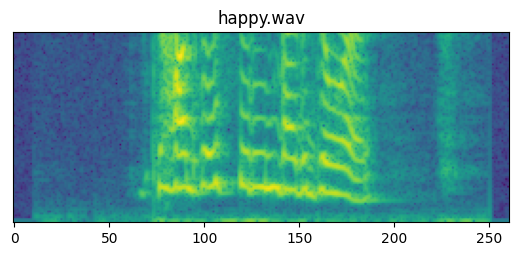

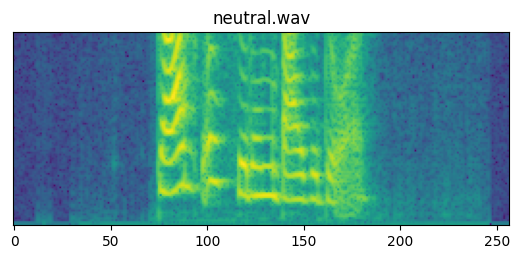

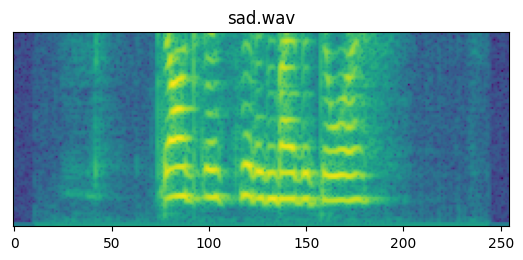

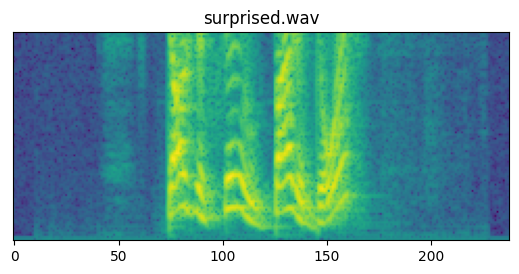

In [10]:
audio_paths = list((Path(path_to_sources) / 'emotional_audios').glob('*.wav'))

for path in audio_paths:
    wav, sr = sf.read(str(path))
    assert sr == SAMPLE_RATE

    Ipd.display(Ipd.Audio(wav, rate=sr))

    spec = calculate_spectrogram(wav).value.T

    max_bins = 100
    plt.imshow(spec[:max_bins], origin="lower")
    plt.title(f'{path.name}')
    plt.yticks([], [])
    plt.show()

The F0 will be located somewhere near the lowest, most prominent stripe on the spectrogram. It is evident that the contours of these stripes vary significantly for different WAV files and that extracting information about F0 could serve as valuable information, for example, in emotion recognition.  

Implement the algorithm for finding F0 as described above.

In [182]:
from typing import Tuple


def compute_cepstrum(xs) -> Tuple[np.array, np.array]:
    '''
    Input: time signal xs
    Return:
        cepstrum: cepstrum values
        quefrencies: qfrequencies (the analog of FFT frequencies, but for Cepstrum)

    Useful functions:
    - np.fft.rfft
    - np.fft.rfftfreq
    '''
    freq = np.fft.rfftfreq(xs.shape[1], d=1/SAMPLE_RATE)
    df = freq[1] - freq[0]
    spectrum = np.fft.rfft(xs, axis=1)
    quefrencies = np.fft.rfftfreq(spectrum.shape[1], d=df)
    cepstrum = np.fft.rfft(np.log(np.abs(spectrum)), axis=1).real
    return cepstrum, quefrencies 


def compute_f0_for_window(cepstrum: np.array, quefrencies: np.array) -> np.array:
    '''
    Input:
        cepstrum: cepstrum values
        quefrencies: qfrequencies (the analog of FFT frequencies, but for Cepstrum)
    Output:
        f0: f0 value for the window (scalar)
    '''
    idxes = np.argwhere(
        (quefrencies >= 1/MAX_PITCH) & (quefrencies <= 1/MIN_PITCH)
    ).flatten()
    q = np.argmax(cepstrum[:, idxes], axis=1) + min(idxes)
    f0 = 1/quefrencies[q]
    return f0


def compute_f0(wav):
    '''
    Computes f0 for an audio:
    - Divides the singal into overlapping windows
    - For each window computes f0
    - Returns an array of each window's result

    Input:
        wav: an array of wav values
    Output:
        f0_values: an array of f0 values

    Useful functions:
    - librosa.util.frame
    - np.hanning
    '''
    windows = librosa.util.frame(
        wav,
        frame_length=WINDOW_LENGTH,
        hop_length=HOP_LENGTH
    ).T
    hann = np.hanning(WINDOW_LENGTH)
    windows = windows * hann
    cepstrum, quefrencies = compute_cepstrum(windows)
    f0_values = compute_f0_for_window(cepstrum, quefrencies)
    return f0_values

In [183]:
path = audio_paths[-1]
wav, _  = sf.read(str(path))
assert compute_f0(wav).shape[0] == calculate_spectrogram(wav).value.shape[0]

Now, let's compare our results with those from the open-source library praat-parselmouth. Keep in mind that your implementation will likely produce noise values in areas where no F0 can be detected, such as in non-voiced regions. This is fine, as we don't apply any noise cancellation post-processing. However, in the regions without noise, the output should closely match what parselmouth provides.

In [184]:
def calculate_parselmouth_pitch(path):
    sound = parselmouth.Sound(str(path))
    pitch_obj = sound.to_pitch(
        pitch_floor=MIN_PITCH,
        pitch_ceiling=MAX_PITCH
    )
    pitch = pitch_obj.selected_array["frequency"]
    pitch = SampledArray(value=pitch, t1=pitch_obj.t1, step=pitch_obj.time_step)
    return pitch


def get_freq_step():
    freqs = np.fft.rfftfreq(n=WINDOW_LENGTH, d=1 / SAMPLE_RATE)
    df = freqs[1] - freqs[0]
    return df

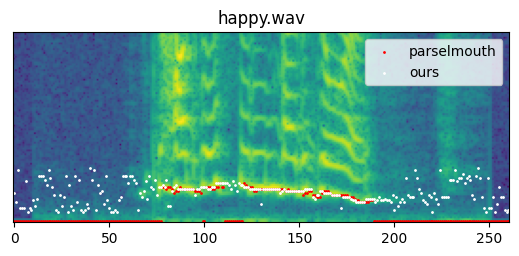

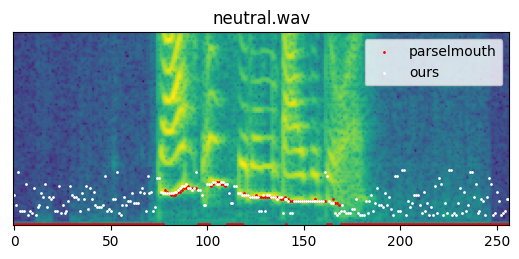

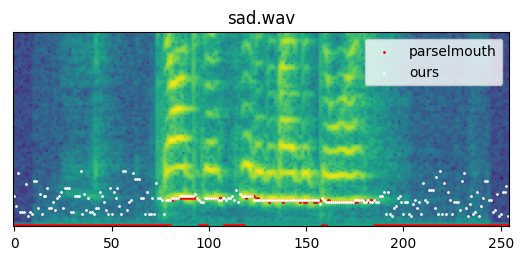

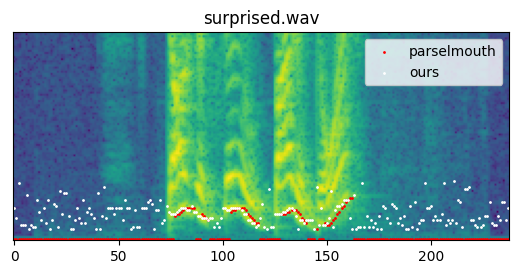

In [186]:
max_bins = 100

for path in audio_paths:
    wav, sr = sf.read(str(path))
    Ipd.display(Ipd.Audio(wav, rate=sr))

    spec = calculate_spectrogram(wav)

    pitch = compute_f0(wav)

    assert compute_f0(wav).shape[0] == calculate_spectrogram(wav).value.shape[0]

    pitch_pm = calculate_parselmouth_pitch(str(path))
    pitch_pm = resample(pitch_pm, spec)

    df = get_freq_step()

    plt.imshow(spec.value.T[:max_bins], origin='lower')
    plt.scatter(x=np.arange(0, spec.value.shape[0]), y=(pitch_pm.value // df).astype(np.int64), label='parselmouth', s=1, c='r')
    plt.scatter(x=np.arange(0, spec.value.shape[0]), y=(pitch // df).astype(np.int64), label='ours', s=1, c='white')
    plt.legend()
    plt.title(f'{path.name}')
    plt.yticks([], [])
    plt.show()

# 02. MAS for duration estimation (2 points)

In this task, you will need to implement MAS (Monotonic Alignment Search) to construct duration estimates.

The task is to find a monotonic alignment along which the sum of log-probabilities is maximized. Such alignment can be uniquely represented as an array, where the i-th position corresponds to the number of steps for the i-th segment in the alignment. In our case, this array can be interpreted as phoneme durations: each row in the alignment corresponds to a phoneme, and the segment in the path found by MAS represents the duration of that phoneme on the spectrogram.

The lecture contains references to useful articles about MAS and formulas for computation.

In [ ]:
def mas_alignment(soft_alignment: np.ndarray):
    """
    Input: soft alignment values after applying logarithm, shape: (len(text), len(mel_spectrogram))
    """
    dp = -np.ones(soft_alignment.shape) * np.inf
    dp[0, 0] = soft_alignment[0, 0]
    for j in range(1, dp.shape[1]):
        dp[0, j] = dp[0, j - 1] + soft_alignment[0, j]
    for i in range(1, dp.shape[0]):
        for j in range(1, dp.shape[1]):
            dp[i, j] = soft_alignment[i, j] + max(dp[i - 1, j - 1], dp[i, j - 1])
    durations = [1]
    cur_i, cur_j = dp.shape[0] - 1, dp.shape[1] - 1
    while cur_j > 0:
        if cur_i > 0 and dp[cur_i, cur_j] == dp[cur_i - 1, cur_j - 1] + soft_alignment[cur_i, cur_j]:
            durations.append(1)
            cur_i -= 1
            cur_j -= 1
        elif dp[cur_i, cur_j] == dp[cur_i, cur_j - 1] + soft_alignment[cur_i, cur_j]:
            durations[-1] += 1
            cur_j -= 1
    return np.array(durations[::-1])

In [227]:
alignment = np.array([
    [1, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 1]
])
assert np.allclose(mas_alignment(alignment), np.array([1, 2, 1]))

alignment = np.array([
    [1, 0.3, 0.1, 0.2],
    [4, 1.2, 1,     5],
    [0, 0,   0,     1]
])
assert np.allclose(mas_alignment(alignment), np.array([1, 2, 1]))

In [228]:
mas_test_path = Path(path_to_sources) / 'mas_test'

alignment = np.load(mas_test_path / 'alignment.npy')
mel = np.load(mas_test_path / 'mel.npy')

wav, sr = sf.read(str(mas_test_path / 'audio.wav'))
Ipd.display(Ipd.Audio(wav, rate=sr))

In [229]:
assert np.allclose(mas_alignment(np.log(alignment).T), np.array([ 1,  5,  5,  6,  8,  5,  8,  7, 14,  1,  9,  1]))

You can try drawing the alignment and seeing how it appears on the mel spectrogram. In the figure created by the `plot_segments` function, the mel spectrogram is at the top, the alignment is at the bottom, and phonemes are in the middle. Red lines show where each phoneme is located on the mel spectrogram based on the alignment.  

The alignment isn’t perfect, which causes a shift to the left after "nn." The phoneme "tt" seems to have taken part of "nn" because "nn" should have evenly spaced harmonics (since it’s a voiced consonant), while "tt" is unvoiced and shouldn't. However, "tt" still has harmonics at the beginning, which suggests a mistake. Also, the phoneme "i" doesn’t show harmonics, even though it should, because it’s a vowel.

In [230]:
def plot_segments(mel, alignment, symbols, title=None):
    f, ax = plt.subplots(2, 1, figsize=(7, 14), sharex=True, dpi=100)
    ax[1].imshow(alignment.T)
    ax[1].set_ylabel('Phonemes', fontsize=12)
    ax[1].set_yticks(np.arange(len(symbols)))
    ax[1].set_yticklabels(symbols, fontsize=7)
    ax[1].set_xlabel('Alignment with mel-spec', fontsize=15)

    ax[0].imshow(mel, origin='lower')
    ax[0].tick_params(axis="x", labelsize=5)
    ax[0].set_ylabel('Mel filters', fontsize=15)
    plt.setp(ax[1].get_xticklabels(), visible=False)

    durations = mas_alignment(alignment.T)
    durations_cs = np.hstack([[0], durations.cumsum()])

    for i, s in enumerate(durations_cs[:-1]):
        shift = -5 if i % 2 else -15
        ax[0].text(
            s, shift * ax[0].get_ylim()[0],# * 20,
            symbols[i],
            fontsize=15,
            weight='bold'
        )

    for s in durations_cs:
        ax[0].axvline(x=s, c='r')
        ax[1].axvline(x=s, c='r')

    f.tight_layout(h_pad=-25)
    f.suptitle('Top: mel spec, bottom: alignment,\nbetween red lines:\nprobable mel spec of a single phoneme', fontsize=20)
    plt.show()

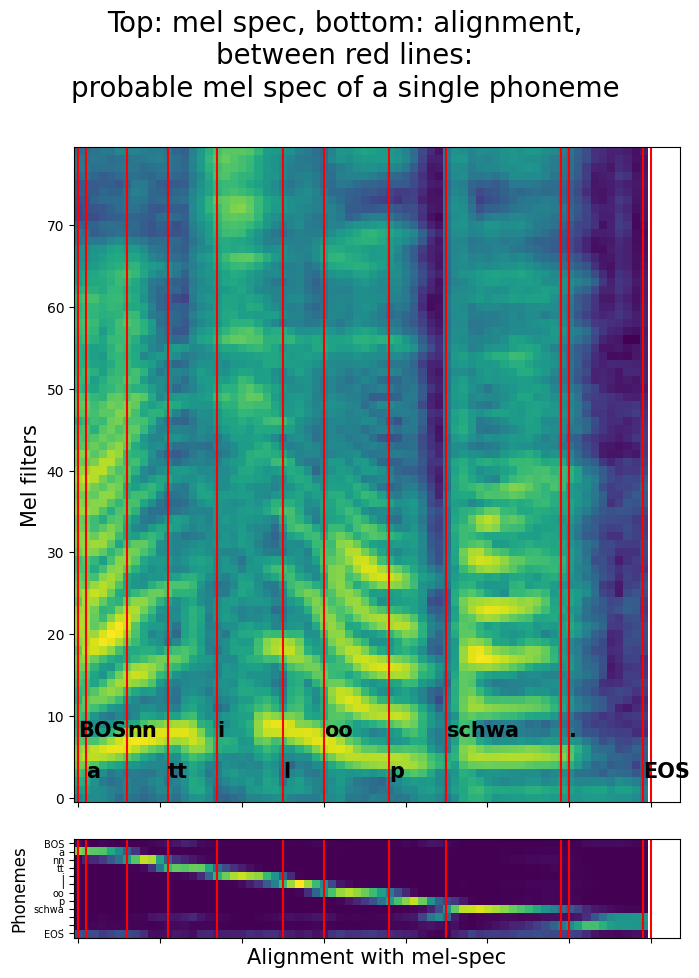

In [231]:
symbols = ['BOS', 'a', 'nn', 'tt', 'i', 'l', 'oo', 'p', 'schwa', ' ', '.', 'EOS']

plot_segments(
    mel,
    alignment,
    symbols
)